# Übung 09: Object Detection

##  Aufgabe 2: Support Vector Machine

In dieser Aufgabe wollen wir Support Vector Machines betrachten. Obwohl auch OpenCV eine Implementation von SVMs beinhaltet möchten wir diesmal die Python Implementation von scikit-learn verwenden. Dazu müsses Sie allenfalls noch das enstprechende Packet mittels `pip3 install sklearn` installieren.

In einer früheren Übung haben wir von unseren Photobox Bildern mit grünen Hintergrund die Hände vom Hintergrund mittels Farbsegemtnierung getrennt. Die Bereiche mussten wir dabei selber finden. In dieser Übung möchten wir eine SVM einsetzen um diese Klassifizierung zu machen.

Zuerst wollen wir die Bilder laden und darstellen.


In [74]:
# OpenCV needs to be included first
import cv2
import numpy as np
from skimage.feature import hog

from tensorflow.keras.datasets import cifar10

# we will use the svm from sklearn
from sklearn import svm

# for displaying images in jupyter

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 200


(576, 864, 3)
(576, 864, 3)


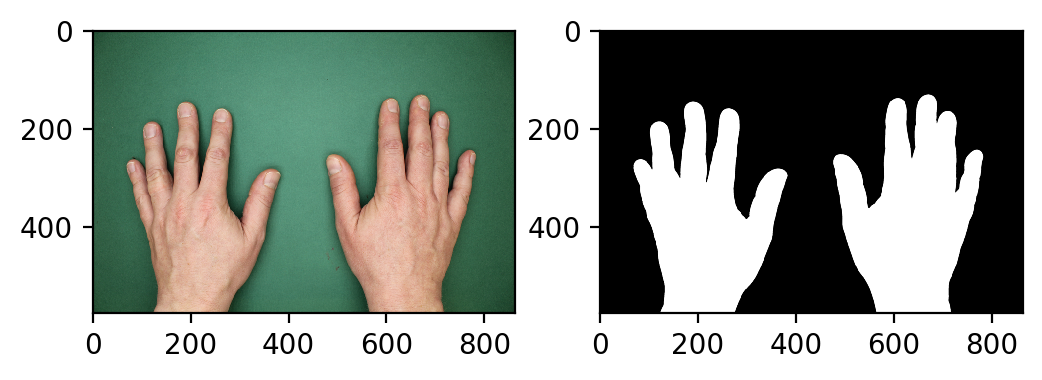

In [75]:
image  = cv2.imread('images/hand_small.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
label = cv2.imread('images/label_small.png')
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(label)
print(image.shape)
print(label.shape)

Als Features für die SVM wollen wir 2D Daten benutzen um sie besser darstellen zu können. Da die Segmentierung auf den Farben basieren soll, zum Beispiel Hue und Saturation. Wir müssen also das Bild in HSV umwandeln.

Die SVM braucht keine Bilddaten, sondern nur ein Array von Werten.

In [76]:
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hs = hsv[:,:,0:2]
data = hs.reshape((-1,2))
print(hs.shape)
print(data.shape)

(576, 864, 2)
(497664, 2)


In [77]:
label_grey = label[:,:,0]
print(label_grey.shape)
classes = label_grey.reshape(-1)
print(classes.shape)

(576, 864)
(497664,)


Da wir Pixel für die Trainingsdaten verwenden, erhalten wir sehr viele Trainings Daten. Für die SVM wird das recht aufwendig, deshalben sollten wir erst mal die Anzahl Daten reduzieren in dem wir nur jedes n-te Pixel nehmen. Späten können wir n verändern um bessere Ergebnisse mit mehr Trainingsdaten zu erhalten.

In [78]:
n = 1000
classes_reduced = classes[1::n]
data_reduced = data[1::n,:]
print(classes_reduced.shape)
print(data_reduced.shape)

(498,)
(498, 2)


Wir können die Features nun als Scatterplot darstellen. Dazu möchten wir die Daten zuerst noch in die positiven und negativen Beispiele unterteilen.


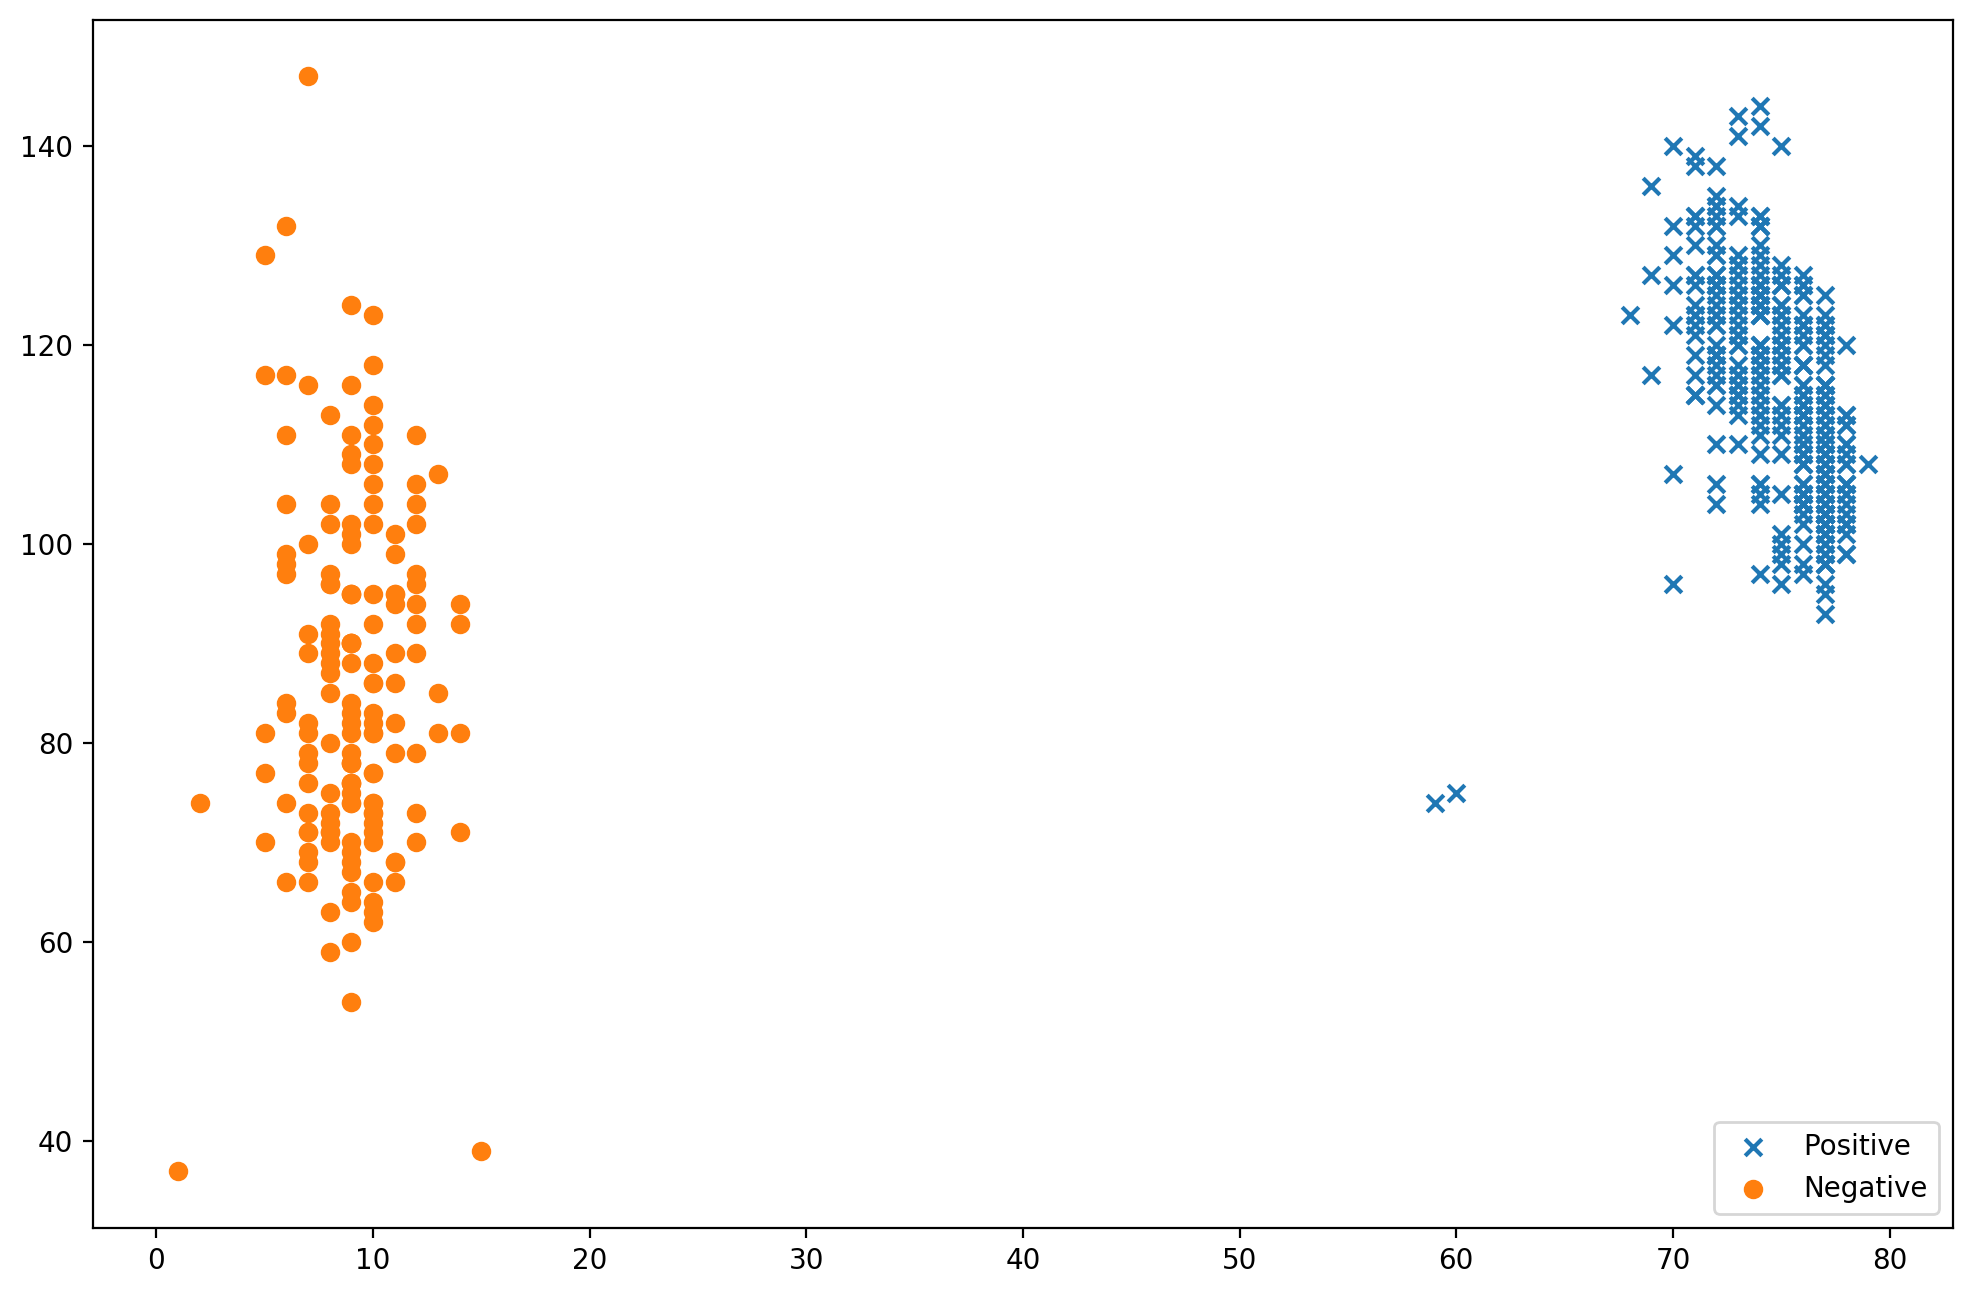

In [79]:
positives = data_reduced[classes_reduced==0]
negatives = data_reduced[classes_reduced==255]
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positives[:,0], positives[:,1], marker='x', label='Positive')
ax.scatter(negatives[:,0], negatives[:,1], marker='o', label='Negative')
ax.legend()

Wir erzeugen einen SVM Klassifier mittels svm.SVC. Der Parameter C bestimmt den Fehlerterm, ein grösserer Wert von C zwingt die SVM mehr Samples richtig zu klassifizieren (auf Kosten von einer glätteren Entscheidungsfunktion).

In [80]:
classifier = svm.SVC(C=1.0, gamma='auto')

Die Funktion fit trainiert den Klassifikator.

In [81]:
classifier.fit(data_reduced, classes_reduced)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [82]:
classifier.score(data,classes)

0.9770286779835391

Laden Sie nun das 2. Bild und überprüfen Sie, welchen Score dass sie auf diesem Bild erreichen mit der bereits trainierten SVM.

Berechnen Sie dann die Klassifizierung, die der Classifier auf den Daten berechnet (mittels predict) und stellen Sie das Resultat wieder als Bild dar (mittels reshape können Sie das 1D Resultat wieder in ein 2D Bild umwandeln)

In [83]:
# load second image
image_2  = cv2.imread('images/hand_small_2.png')
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
# convert it to hsv
hsv_2 = cv2.cvtColor(image_2, cv2.COLOR_RGB2HSV)
# just use hue and saturation
hs_2 = hsv_2[:,:,0:2]
# reshape 2D image in 1D image
data_2 = hs_2.reshape((-1,2))
print(data_2.shape)

# let already trained classifier predict classification of each pixel for new image
classified_image = classifier.predict(data_2)
print(classified_image.shape)

(497664, 2)
(497664,)


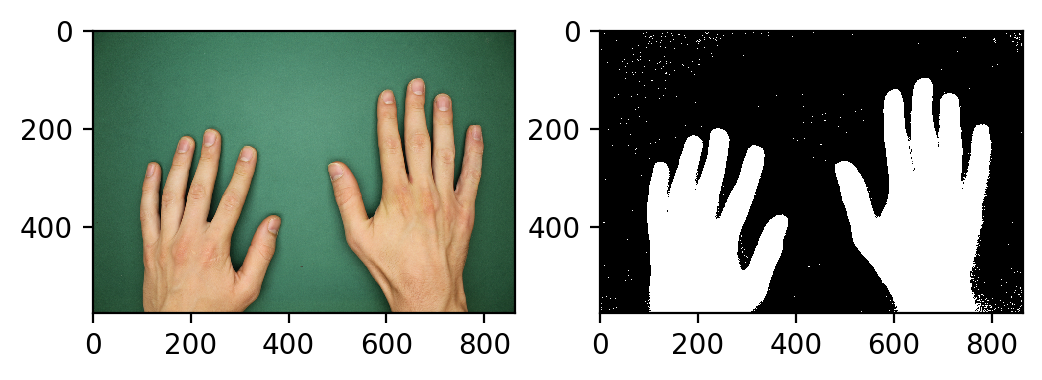

In [84]:
classified_image = classified_image.reshape((576,864,1))
classified_image = cv2.cvtColor(classified_image,cv2.COLOR_GRAY2RGB)
plt.subplot(1, 2, 1)
plt.imshow(image_2)
plt.subplot(1, 2, 2)
plt.imshow(classified_image)

## Aufgabe 3: SVM für Bild Klassifizierung

In dieser Aufgabe wollen wir nun statt einzelne Pixel ganze Bilder Klassifizieren. Dazu verwenden wir den CIFAR-10 Datensatz. Dieser enthält 50000 Bildern der Grösse 32x32x3 von 10 verschiedenen Klassen.

In [107]:
(x_image_train, y_train), (x_image_test, y_test) = cifar10.load_data()
print(x_image_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


Wir möchten zuerst einige Bilder zufällig darstellen.

In [108]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def show_images(images, labels):
    fig, axes = plt.subplots(3, 5)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        example = np.random.randint(len(images))
        ax.imshow(images[example])
        
        # Name of the true class.
        cls_true_name = label_names[labels[example, 0]]
        xlabel = "{0}".format(cls_true_name)
        
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    return

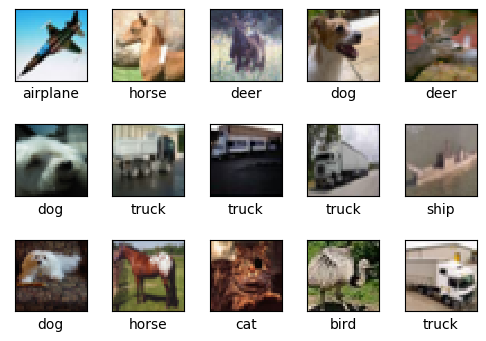

In [109]:
mpl.rcParams['figure.dpi']= 100
show_images(x_image_train, y_train)

Für die SVM brauchen wir Features, die aus den Bildern berechnet werden. Dazu möchten wir HOG Features verwenden. Schauen wir uns diese Features auf einem Beispiel Bild an:

In [110]:
example_hog = hog(x_image_train[0],multichannel=True)
print(example_hog.shape)
print(example_hog)

(324,)
[0.13464152 0.07272896 0.17320919 0.02151617 0.08840006 0.02113604
 0.00924969 0.00949186 0.02207347 0.09449433 0.04561067 0.11445538
 0.06574611 0.0972882  0.00966041 0.02669958 0.01632831 0.03035555
 0.02433771 0.06186661 0.02486516 0.06848729 0.11305132 0.13554185
 0.06792958 0.09204484 0.03925407 0.08336985 0.07168053 0.03545781
 0.05701544 0.06903753 0.04320495 0.02712104 0.01784631 0.05129074
 0.20618169 0.22664725 0.15594272 0.22664725 0.16020278 0.0733445
 0.         0.05120455 0.04497185 0.01010414 0.         0.06717468
 0.1491951  0.22664725 0.22664725 0.15358546 0.02591799 0.14732247
 0.11493091 0.22019368 0.08083512 0.03174157 0.03708767 0.12052118
 0.04146982 0.03959274 0.08098859 0.21236983 0.22664725 0.22664725
 0.07984992 0.08946831 0.06480731 0.08032986 0.1205062  0.09054558
 0.02123494 0.0639888  0.09142067 0.22664725 0.21818665 0.10563168
 0.04270599 0.09992789 0.09288129 0.0913093  0.04407332 0.11059755
 0.06353008 0.09400901 0.0093348  0.02579964 0.01577795 

Für SVM sind 50000 Bilder etwas viel, deshalb wollen wir für den Anfang weniger verwenden und den Anteil erhöhen. Dazu samplen wir 10000 Indizes.

In [111]:
indices = np.random.choice(x_image_train.shape[0], 10000, replace=False)
print(max(indices))
print(indices)

49989
[32543 26897 44937 ...  4050 13565   238]


In [112]:
x_image_train_small = x_image_train[indices, :, :, :]
y_train_small = y_train[indices, :]
print(x_image_train_small.shape)
print(y_train_small.shape)

(10000, 32, 32, 3)
(10000, 1)


Von diesen Bildern sollen nun die Hog Features berechnet werden.

In [113]:
def calculate_features_hog(x):
    feature_vec = []
    for i in range(x.shape[0]):
        f = hog(x[i], multichannel=True)
        feature_vec.append(f)
    return np.asarray(feature_vec)

Berechnen sie nun die Features auf den 5000 Hog Features... 

In [114]:
feature_vec = calculate_features_hog(x_image_train_small)
print(feature_vec.shape)
print(feature_vec)

(10000, 324)
[[0.10353871 0.1660969  0.13478211 ... 0.03496959 0.02000304 0.01113558]
 [0.12440644 0.08953039 0.13842387 ... 0.05833159 0.00572858 0.        ]
 [0.0029906  0.         0.         ... 0.         0.         0.00308316]
 ...
 [0.02195359 0.01458624 0.01208229 ... 0.00887233 0.00374736 0.        ]
 [0.15537023 0.05714666 0.01258708 ... 0.01754322 0.00478615 0.07117057]
 [0.0359344  0.05531397 0.0669564  ... 0.02180469 0.05372828 0.05044404]]


 und trainieren sie eine SVM auf diesen Features:

In [115]:
svc_classifier = svm.SVC(C=1.0, gamma='auto')
svc_classifier.fit(feature_vec, y_train_small.ravel())

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Um das Resultat auszuwerten wollen wir die confusion matrix berechnen und anzeigen. Dazu müssen wir 
mit classifier.predict zuerst die Prediction berechnen. Anschliessend kann die Confusion Matrix mittels
 sklearn.metrics.confusion_matrix berechnet werden.

In [116]:
prediction = svc_classifier.predict(calculate_features_hog(x_image_train))
print(prediction)

[1 9 1 ... 4 8 1]


In [117]:
import sklearn
sklearn.metrics.confusion_matrix(y_train, prediction)

array([[2081,  539,   41,   10,  819,  214,   12,   11, 1165,  108],
       [ 108, 3434,    1,    5,  475,   63,   51,    7,  559,  297],
       [ 497,  480,  140,   55, 1957, 1559,   32,   20,  164,   96],
       [ 121,  434,    4,  104, 1922, 2072,   24,   49,   67,  203],
       [ 228,  570,    3,   11, 3134,  692,    0,   22,  144,  196],
       [  54,  252,    4,   30, 1467, 3018,   22,   37,   14,  102],
       [ 126,  591,    8,   84, 3147,  773,  164,   24,   34,   49],
       [ 164,  455,   10,    5, 2843,  930,    1,  260,   52,  280],
       [ 554, 1055,    8,   12,  446,  119,   15,    9, 2387,  395],
       [ 122, 1009,    2,   10,  680,  247,    3,   30,  414, 2483]])

Die Funktion sklearn.metrics.classification_report zeigt eine Übersicht über das Ergebnis:

In [118]:
print(sklearn.metrics.classification_report(y_train, prediction))

              precision    recall  f1-score   support

           0       0.51      0.42      0.46      5000
           1       0.39      0.69      0.50      5000
           2       0.63      0.03      0.05      5000
           3       0.32      0.02      0.04      5000
           4       0.19      0.63      0.29      5000
           5       0.31      0.60      0.41      5000
           6       0.51      0.03      0.06      5000
           7       0.55      0.05      0.10      5000
           8       0.48      0.48      0.48      5000
           9       0.59      0.50      0.54      5000

    accuracy                           0.34     50000
   macro avg       0.45      0.34      0.29     50000
weighted avg       0.45      0.34      0.29     50000



Natürlich sollten wir das auf dem Test Set und nicht auf dem Trainings Set auswerten. Wie sehen die Resultate da aus?

In [119]:
prediction_test = svc_classifier.predict(calculate_features_hog(x_image_test))

In [120]:
print(sklearn.metrics.classification_report(y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.52      0.42      0.46      1000
           1       0.38      0.66      0.48      1000
           2       0.73      0.03      0.06      1000
           3       0.21      0.01      0.03      1000
           4       0.19      0.65      0.29      1000
           5       0.31      0.59      0.41      1000
           6       0.54      0.04      0.07      1000
           7       0.53      0.05      0.09      1000
           8       0.47      0.48      0.47      1000
           9       0.59      0.49      0.54      1000

    accuracy                           0.34     10000
   macro avg       0.45      0.34      0.29     10000
weighted avg       0.45      0.34      0.29     10000

